# Direct methods for solving linear systems

The pourpose of this exercise is becoming familiar with some direct methods for solving linear systems and play with the **LU** and **Cholesky** decompositions.


Let us consider an elastic cable fixed at the extremes occupying at rest the space $[0,1]$. We apply on it a given force $f(x)$. Its displacement at the point $x$, $u(x)$ is the solution of the following problem:
$$
-u_h''(x) = f(x)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h(1) = 0
$$

For the sake of simplicity we consider a uniform discretisation of the interval $[0,1]$ using $n$ equispaced *sample points* to construct a **Finite Difference Approximation**.

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

n = 33
h = 1./(n-1)

x=linspace(0,1,n)

# Central finite difference approximation

We consider the approximation

$$
-u''_i := \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$

and solve the linear system

$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad i=1,\ldots,n-2
$$

This results in a tridiagonal matrix with $n-2$ entries. We assemble all of the entries anyway, and then perform a **line elimination** to make the system solvable. This is typical of problems with **Dirichlet Boundary conditions**.

In [2]:
a = -ones((n-1,)) # Offdiagonal entries
b = 2*ones((n,)) # Diagonal entries
A = (diag(a, -1) + diag(b, 0) + diag(a, +1))
print(A)

# Now we scale it to 1/h^2
A /= h**2

print(linalg.cond(A))

[[ 2. -1.  0. ...,  0.  0.  0.]
 [-1.  2. -1. ...,  0.  0.  0.]
 [ 0. -1.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  2. -1.  0.]
 [ 0.  0.  0. ..., -1.  2. -1.]
 [ 0.  0.  0. ...,  0. -1.  2.]]
467.842628839


Now let's consider a simple right hand side:

$$
f_i = x_i(1-x_i)
$$
which gives as exact solution

$$
u_{\mathrm{exact}} = \frac{x^4}{12} - \frac{x^3}{6} +\frac{x}{12}
$$


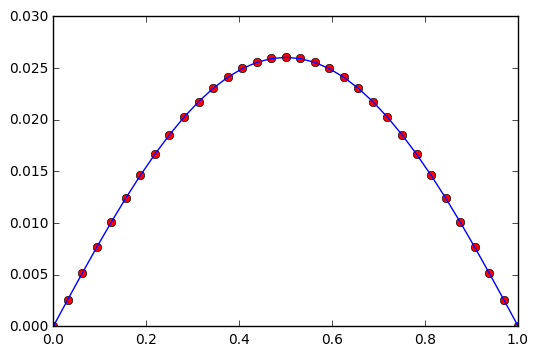

In [20]:
f =x*(1.-x)

# Put a one on the diagonal in the first and last lines
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1./h**2

A[:,-1] = 0
A[-1,:] = 0
A[-1,-1] = 1./h**2

f[0] = 0
f[-1] = 0

A1 = A.copy()



u = linalg.solve(A1, f)

u_ex = (x**4)/12. - (x**3)/6. + x/12.

_ = plot(x,u,'ro')
_ = plot(x,u_ex)


## LU decomposition

We want to implement our linear solver using an **LU decomposition** (without pivoting for now)
$$
A = LU
$$
and so the system 
$$
Ax=b
$$
can be solved in **two steps**
$$
Ly=b
$$
$$
Ux=y
$$

For the sake of simplicity, you can use the following function to compute the LU decomposition of a square matrix A (of course you can try to implement it by your own..)

In [21]:
def LU(A1):
    A = A1.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            print "error"
            exit
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)



Now you have to code the solution of a linear system when the matrix A is a **lower triangular matrix** and when it is an **upper triangular matrix**

In [22]:
def L_solve(L,rhs):
    x=zeros_like(rhs)
    N = len(L)

    if (abs(min(diag(L))) < 1e-15):
        print "error"
        exit
    
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i,:i], x[:i]))/L[i,i]
    
    return x


In [23]:
def U_solve(U,rhs):
    x=zeros_like(rhs)
    N=len(U)
    
    if (abs(min(diag(L))) < 1e-15):
        print "error"
        exit
    
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N-1],x[i+1:N-1]))/U[i,i]
           
    return x


Now let's solve the system 
$$ 
Ax=b
$$

and compare the solution with respect to the exact solution given above

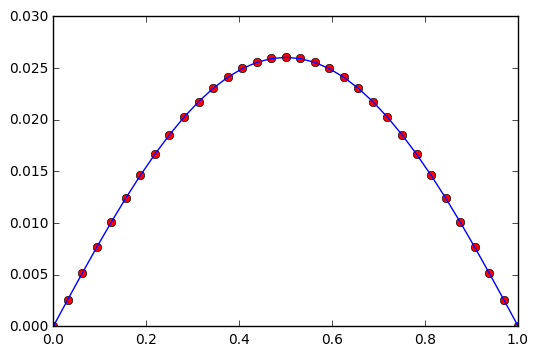

In [24]:
y = L_solve(L,f)

u = U_solve(U,y)

_ = plot(x,u,'ro')
_ = plot(x,u_ex)




### try to compute the solution $u(x)$ with different forcing terms and compare with the exact solution **without recomputing the LU decomposition**

In [25]:
# YOUR CODE HERE

## Cholesky decomposition
For symmetric and positive define matrices, the Cholesky is preferred since it reduce the number of flops for computing the LU decomposition by a factor of 2.

$$
A = H^T H
$$
where $H$ is an upper triangular matrix with all positive elements on the diagonal

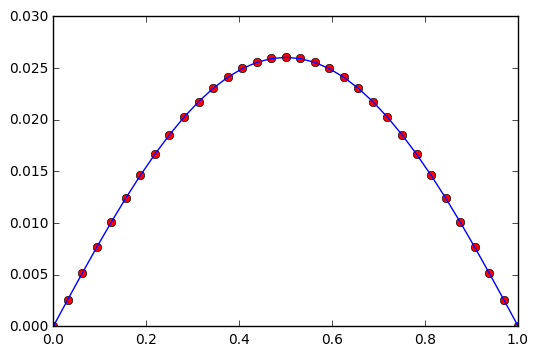

In [26]:
def cholesky(A1):
    A = A1.copy()
    N = len(A)
    for k in range(N-1):
        #print k
        #print A[k,k]
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()


HT, H = cholesky(A)

y = L_solve(HT,f)
u = U_solve(H,y)


_ = plot(x,u,'ro')
_ = plot(x,u_ex)

### Comparison
Time the two factorisations for three different matrix sizes (e.g., 1000, 2000, 3000) and plot the amounts of time. Verify that they scale as $N^3$